In [31]:
import pandas as pd
import geopandas as gpd
from pyproj import Transformer
import networkx as nx
import folium

In [27]:
# Convert Node Coordinates from Illinois to Long/Lat
node_file = "ChicagoSketch_node.tntp"

nodes = []
reading_date = False
with open(node_file, "r") as file:
    for line in file:
        line = line.split(";")[0]
        print(line)
        if line.startswith("node"):
            reading_date = True
            continue
        if not reading_date or line.startswith("~") or line == "":
            continue
        print(line)
        parts = line.split()
        print(parts)
        if len(parts) >= 3:
            node_id, x, y = int(parts[0]), float(parts[1]), float(parts[2])
            nodes.append((node_id, x, y))
            # node_id = int(parts[0])
            # x, y = map(float, parts[1:3])
            # transformer = Transformer.from_crs("epsg:26918", "epsg:4326")

# Convert to DataFrame
df_nodes = pd.DataFrame(nodes, columns=["Node", "X", "Y"])

# Convert Illinois State Plane (EPSG:3435) to Latitude/Longitude (EPSG:4326)
transformer = Transformer.from_crs("EPSG:3435", "EPSG:4326", always_xy=True)
df_nodes["Lon"], df_nodes["Lat"] = zip(*df_nodes.apply(lambda row: transformer.transform(row["X"], row["Y"]), axis=1))

# Convert to GeoDataFrame
gdf_nodes = gpd.GeoDataFrame(df_nodes, geometry=gpd.points_from_xy(df_nodes["Lon"], df_nodes["Lat"]), crs="EPSG:4326")

gdf_nodes.to_csv("chicago_nodes_transformed.csv", index=False)

node	X	Y	
1	690309	1976022	
1	690309	1976022	
['1', '690309', '1976022']
2	683649	1973025	
2	683649	1973025	
['2', '683649', '1973025']
3	693306	1963368	
3	693306	1963368	
['3', '693306', '1963368']
4	686313	1958373	
4	686313	1958373	
['4', '686313', '1958373']
5	696636	1946718	
5	696636	1946718	
['5', '696636', '1946718']
6	671328	1968030	
6	671328	1968030	
['6', '671328', '1968030']
7	676323	1957041	
7	676323	1957041	
['7', '676323', '1957041']
8	655677	1967031	
8	655677	1967031	
['8', '655677', '1967031']
9	649350	1952712	
9	649350	1952712	
['9', '649350', '1952712']
10	665667	1949049	
10	665667	1949049	
['10', '665667', '1949049']
11	666333	1933398	
11	666333	1933398	
['11', '666333', '1933398']
12	676323	1935396	
12	676323	1935396	
['12', '676323', '1935396']
13	677988	1924407	
13	677988	1924407	
['13', '677988', '1924407']
14	679653	1945719	
14	679653	1945719	
['14', '679653', '1945719']
15	688977	1936062	
15	688977	1936062	
['15', '688977', '1936062']
16	692307	1925739	
16	69230

[(1, 547, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (2, 548, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (3, 549, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (4, 550, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (5, 551, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (6, 552, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (7, 553, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (8, 554, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (9, 555, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (10, 556, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (11, 557, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (12, 558, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (13, 559, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (14, 560, {'capacity

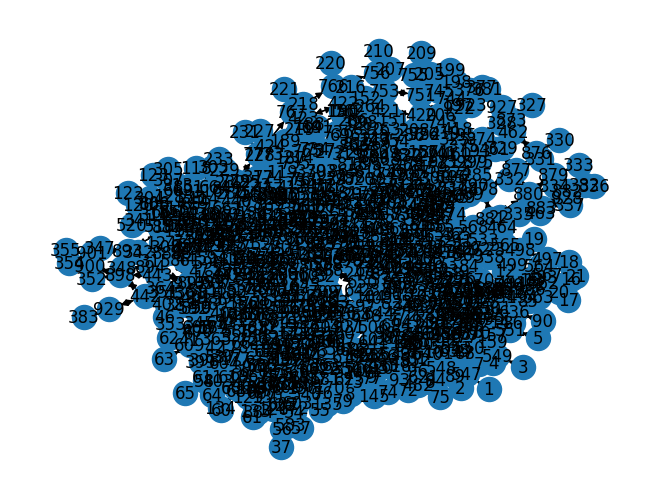

In [33]:
# Load the Road Network (ChicagoSketch_net.tntp)
network_file = "ChicagoSketch_net.tntp"
edges = []
reading_data = False

with open(network_file, "r") as file:
    for line in file:
        if line.startswith("<END OF METADATA>"):
            reading_data = True
            continue
        if not reading_data or line.startswith("~") or line.startswith("<") or line == "":
            continue
        line = line.split(";")[0]
        parts = line.split()
        if len(parts) >= 6:
            init_node, term_node = int(parts[0]), int(parts[1])
            capacity, length, free_flow_time = map(float, parts[2:5])
            edges.append((init_node, term_node, {"capacity": capacity, "length": length, "free_flow_time": free_flow_time}))
G = nx.DiGraph()
G.add_edges_from(edges)
nx.draw(G, with_labels=True)

print(edges)


In [32]:
# Create Chicago map
m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)

# Add roads to map
for edge in edges:
    start, end, attr = edge
    lon1, lat1 = df_nodes.loc[df_nodes["Node"] == start, ["Lon", "Lat"]].values[0]
    lon2, lat2 = df_nodes.loc[df_nodes["Node"] == end, ["Lon", "Lat"]].values[0]

    # Color roads based on free-flow time
    color = "green" if attr["free_flow_time"] < 5 else "orange" if attr["free_flow_time"] < 10 else "red"

    folium.PolyLine([(lat1, lon1), (lat2, lon2)], color=color, weight=3, opacity=0.7).add_to(m)

# Display map
m
